In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display 
import librosa as lb
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')                  # Filter the warnings and ignore it

In [13]:
df = pd.read_csv('metadata/UrbanSound8K.csv')

In [14]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [15]:
data,sr = lb.load(path='audio/fold5/100263-2-0-117.wav')

In [17]:
print(data.shape)               
print(sr)                           # 22.05 kHz

(88200,)
22050


In [21]:
ipd.Audio(data,rate=sr)

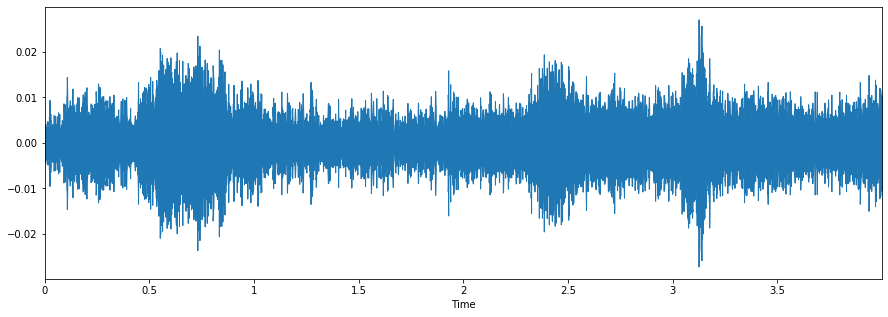

In [28]:
plt.figure(figsize=(15,5))
librosa.display.waveplot(data,sr=sr)
# plt.plot(data)

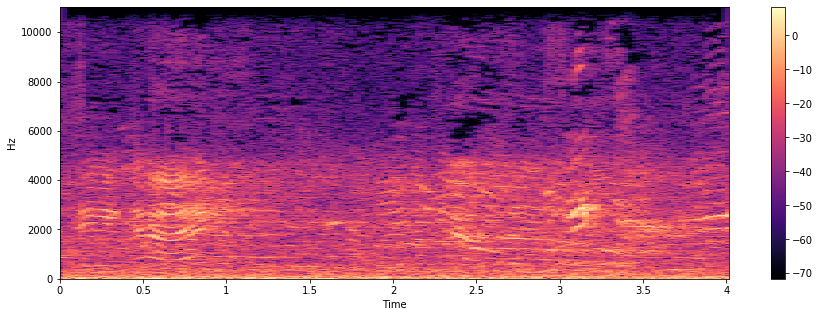

In [37]:
# spectogram
plt.figure(figsize=(15,5))
data_stft = lb.amplitude_to_db(np.abs(lb.stft(data)))
librosa.display.specshow(data_stft,x_axis='time',y_axis='hz')
plt.colorbar()

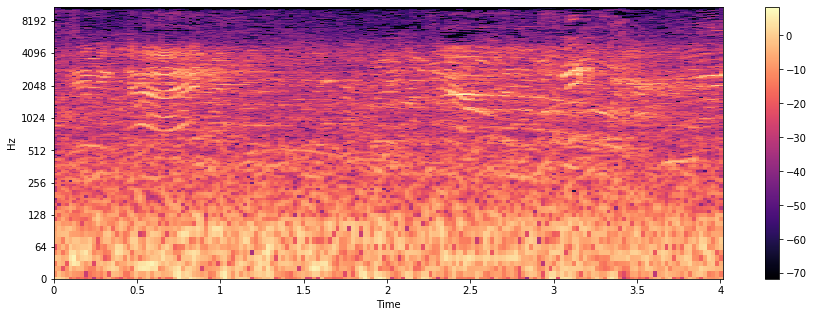

In [38]:
# Logarithmic Scale
plt.figure(figsize=(15,5))
data_stft = lb.amplitude_to_db(np.abs(lb.stft(data)))
librosa.display.specshow(data_stft,x_axis='time',y_axis='log')
plt.colorbar()

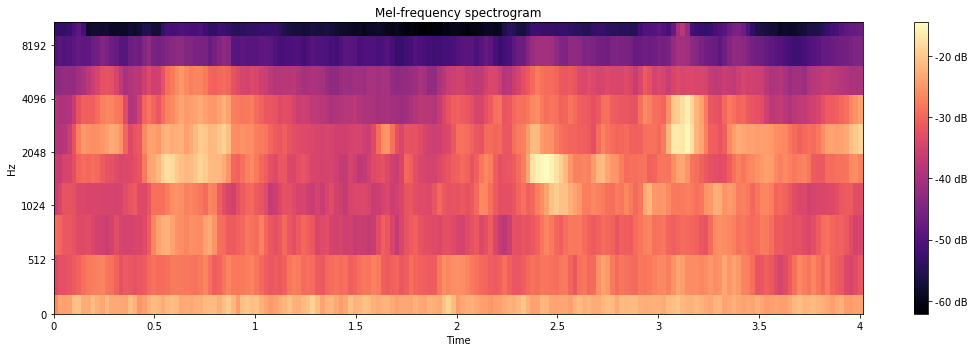

In [47]:
# melspectogram
plt.figure(figsize=(15,5))
data_mel = lb.feature.melspectrogram(y=data,sr=sr,n_mels=10)
S_dB = librosa.power_to_db(data_mel)
librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()


# Zero Crossing Rate

The zero-crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to zero to negative or from negative to zero to positive. This feature has been used heavily in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.

ZCR is defined formally as

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/cda9c9054c26350f517732f08eb791d232b7c1ba'>

In [63]:
zero_cross = lb.zero_crossings(data[5000:5050],pad=False)
#print(zero_cross.shape)
stack = librosa.util.stack([data[5000:5050], zero_cross], axis=-1)
#print(stack.shape)
#type(stack)
np.nonzero(stack)               # array indices for the zero_cross


(array([ 0,  1,  1,  2,  3,  4,  4,  5,  6,  7,  8,  9, 10, 10, 11, 12, 13,
        13, 14, 15, 16, 17, 17, 18, 19, 20, 20, 21, 22, 23, 24, 25, 25, 26,
        27, 28, 29, 29, 30, 31, 32, 33, 33, 34, 35, 36, 37, 37, 38, 39, 40,
        41, 42, 43, 44, 44, 45, 45, 46, 47, 48, 49], dtype=int64),
 array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int64))

# Spectral Centroid

The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.
It is calculated as the weighted mean of the frequencies present in the signal, determined using a Fourier transform, with their magnitudes as the weights:

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/0a62c839a6ceafd854138264d81b2986d8cdaff1'>

In [70]:
spectral_centroids = lb.feature.spectral_centroid(y=data,sr=sr)[0]
print(spectral_centroids.shape)

(173,)


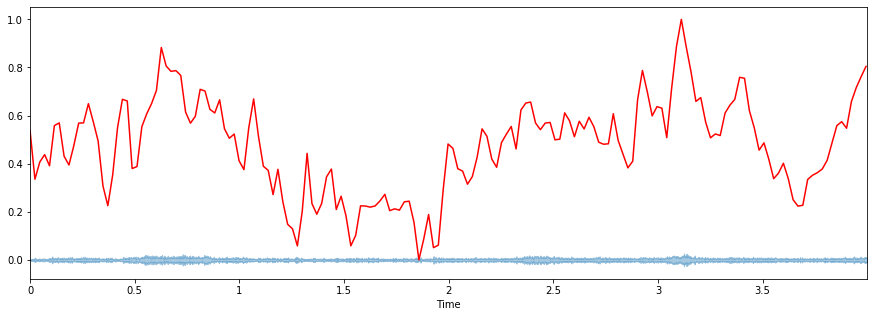

In [77]:
plt.figure(figsize=(15,5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
#print(t)

from sklearn.preprocessing import minmax_scale
mp_scale = minmax_scale(spectral_centroids,axis=0)
librosa.display.waveplot(data, sr=sr, alpha=0.4)
plt.plot(t, mp_scale, color='r')

# MFCC

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

MFCCs are commonly derived as follows:

1> Take the Fourier transform of (a windowed excerpt of) a signal.
2> Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
3> Take the logs of the powers at each of the mel frequencies.
4> Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
5> The MFCCs are the amplitudes of the resulting spectrum.


In [83]:
mffcs = lb.feature.mfcc(y=data,sr=sr,n_mfcc=13)
#mffcs
print(mffcs.shape)

(13, 173)


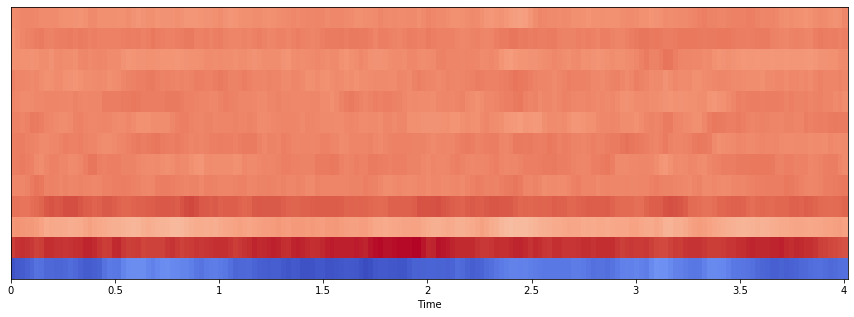

In [87]:
plt.figure(figsize=(15,5))
lb.display.specshow(mffcs,sr=sr,x_axis='time')